# Google Traces Analysis


In [1]:
#TRACES_BASE_PATH='/mnt/stockage/leo/google-traces/clusterdata-2011-2'
TRACES_BASE_PATH='clusterdata-2011-2'
TRACES_PREPROCESSED_PATH='preprocessed.csv'

In [2]:
%matplotlib inline
#import cython
#%load_ext Cython

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os

import pandas as pd
import seaborn as sn

figsize_base = (6.0, 4.0)
plt.rcParams['figure.figsize'] = (6.0, 4.0)
base_image_path = "figures"

def save_fig(name, extension="pdf", add_param={}):
    plt.savefig(os.path.join(base_image_path, "{}.{}".format(name, extension)), bbox_inches="tight", **add_param)


In [4]:
MAIN_OUTPUT_DIR = 'final_output'

# create and return a composed path...
def output_file_autocreate(*paths, base=MAIN_OUTPUT_DIR):
    dirpath = os.path.join(base, *paths[:-1])
    os.makedirs(dirpath, exist_ok=True)
    return os.path.join(dirpath, paths[-1])

#ROOT_FIG_OUTPUT = 'final_output'
def savefig_article(fig, *paths, root_output=MAIN_OUTPUT_DIR, lgd=None):
    filename = output_file_autocreate(*paths, base=root_output)
    extra = (lgd,) if lgd is not None else ()
    fig.savefig(filename, bbox_extra_artists=extra, bbox_inches='tight')

In [5]:
# a few default settings for good-looking figures
DEFAULT_FIGSIZE_HALF=(4,3/5*4)
DEFAULT_FIGSIZE_BORDERLINE=(5,3)

In [6]:
import dask
from dask import dataframe as daskdf

In [7]:
#tracesPath='/var/tmp/clusterdata-2011-2'
#tracesPath='/mnt/stockage/leo/google-traces/clusterdata-2011-2'
#tasksNums = range(0,500)
tasksNums = range(0,10)

In [8]:
tasksFiles=list(map(lambda x: os.path.join(TRACES_BASE_PATH, 'task_events/part-'+str(x).zfill(5)+'-of-00500.csv.gz'), tasksNums))

In [9]:
print(tasksFiles[0])
print('to')
print(tasksFiles[-1])

clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz
to
clusterdata-2011-2/task_events/part-00499-of-00500.csv.gz


## Simple attempt to use Pandas
Should allow compact reading...

In [10]:
LIMITED_LOAD=False

nrows=None
if LIMITED_LOAD:
    nrows = 100000

In [11]:
col_names = ['lastevt', 'subtime', 'sclass', 'prio', 'diff', 'diffrel', 'mt']
col_types = {
    'lastevt': np.int8,
    'subtime': np.int64,
    'sclass': np.int8,
    'prio': np.int8,
    'diff': np.float32,
    'diffrel': np.float32,
    'mt': np.float32,
}

if False:
    preproc_df = pd.read_csv(TRACES_PREPROCESSED_PATH, header=None, names=col_names, dtype=col_types, nrows=nrows)
    # XXX do not use if arrival time is unknown (before traces begin)
    # rational : make results wrong
    preproc_df = preproc_df.loc[preproc_df.subtime > 0]

In [12]:
%%time
# temp
delayed_preproc_df = daskdf.read_csv(TRACES_PREPROCESSED_PATH, header=None, names=col_names, dtype=col_types, nrows=nrows)

CPU times: user 67.8 ms, sys: 410 µs, total: 68.2 ms
Wall time: 67.2 ms


In [116]:
delayed_preproc_df['mt'].max().compute()

2505834.5

In [117]:
3600*24*29

2505600

In [27]:
endevt = delayed_preproc_df.query('subtime > 0').groupby('lastevt')['diff'].count().compute()

In [28]:
dict(endevt)

{4: 18207839, 5: 9283627}

In [29]:
schedclasses = delayed_preproc_df.query('subtime > 0').groupby('sclass')['diff'].count().compute()
dict(schedclasses)

{0: 21020501, 1: 3383863, 2: 3002172, 3: 84930}

In [30]:
%%time
combinations = delayed_preproc_df.query('subtime > 0').groupby(['sclass', 'prio'])['diff'].count().compute()
dict(combinations)

CPU times: user 38.2 s, sys: 1.54 s, total: 39.7 s
Wall time: 11.7 s


In [113]:
def compute_mass_at_time(delayed_df, resolution=10000):
    #NB_INDEX_MAX = 10000
    #mass_at_time = [0]*(resolution+1)
    mass_at_time = np.array([0]*(resolution+1), dtype=np.int32)
    
    # itterating over rows is too costly, get them as array and manipulate them (more memory, but acceptable for ~30M tasks)
    subtimes = (delayed_df.subtime / 1000000).compute()
    endtimes = subtimes + delayed_df.mt.compute()
    
    submin = min(subtimes)
    submax = max(subtimes)

    def time_to_idx(time, mintime=submin, maxtime=submax, maxidx=resolution):
        return int((time - mintime) / (maxtime - mintime) * maxidx)

    for subtime, endtime in zip(subtimes, endtimes): #delayed_preproc_df.query('lastevt == 4').iterrows():
        #subtime = row.subtime / 1000000
        #endtime = row.mt + subtime
        
        mass_at_time[time_to_idx(subtime):time_to_idx(endtime)+1] += 1

        #for i in range(time_to_idx(subtime), time_to_idx(endtime)+1):
        #    mass_at_time[i] += 1
            
    times = (np.arange(resolution+1)*(submax - submin) + submin)/(resolution)
    return times, mass_at_time


In [120]:
%%time
# Finish event: 4 (including already submitted tasks) -> subtime > 0 and ...
mass_finish = compute_mass_at_time(delayed_preproc_df.query('lastevt == 4'), resolution=30*24*60)

CPU times: user 3min 18s, sys: 4.55 s, total: 3min 22s
Wall time: 2min 37s


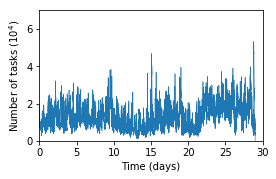

In [144]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_HALF)
times, mass = mass_finish
ax.plot(times/(3600*24), mass/10000, linewidth=0.6)
ax.set_xlim(0,30)
ax.set_ylim(0,7)
ax.set_xlabel('Time (days)')
#ax.yaxis.get_major_formatter().set_powerlimits((-4,3))
ax.set_ylabel('Number of tasks ($10^4$)')
savefig_article(fig, 'mass_finished.pdf')

In [121]:
%%time
# Kill event: 5, including the tasks starting before the window...
mass_killed = compute_mass_at_time(delayed_preproc_df.query('lastevt == 5'), resolution=30*24*60)

CPU times: user 2min 16s, sys: 3.87 s, total: 2min 20s
Wall time: 1min 35s


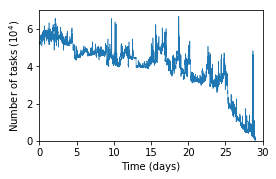

In [143]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_HALF)
times, mass = mass_killed
ax.plot(times/(3600*24), mass/10000, linewidth=0.6)
ax.set_xlim(0,30)
ax.set_ylim(0,7)
ax.set_xlabel('Time (days)')
#ax.yaxis.get_major_formatter().set_powerlimits((-4,3))
ax.set_ylabel('Number of tasks ($10^4$)')
savefig_article(fig, 'mass_killed.pdf')

In [147]:
delayed_preproc_df['diff'].describe().compute()

count    2.755278e+07
mean     2.102070e+02
std      2.568105e+03
min      0.000000e+00
25%      2.110590e+00
50%      4.584013e+00
75%      4.113106e+01
max      1.196001e+06
dtype: float64

In [148]:
delayed_preproc_df['diffrel'].describe().compute()

count    27552781.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
dtype: float64

In [35]:
%%time
means = delayed_preproc_df.query('subtime > 0').groupby('prio')['mt'].mean().compute()
stds = delayed_preproc_df.query('subtime > 0').groupby('prio')['mt'].std().compute()

CPU times: user 1min 21s, sys: 4.87 s, total: 1min 26s
Wall time: 31.6 s


In [39]:
# no prio 7 and 11 in original paper
means = dict(means)
means[7] = 0
means[11] = 0
stds = dict(stds)
stds[7] = 0
stds[11] = 0

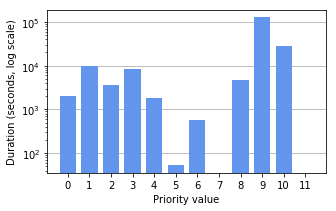

In [45]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_BORDERLINE)
#fig.set_size_inches(10.0, 5.0)
#plt.title('Distribution of priority groups for each scheduling class for finishing tasks')

xes = np.arange(12)
yes = [means.get(x, 0) for x in xes]
#errs = [stds.get(x, 0) for x in xes]
errs = None

ind = np.arange(4)
width = 0.75
rects = []
#for i in range(4):
rects.append(ax.bar(xes, yes, width=width, yerr=errs, color='cornflowerblue', edgecolor='none', zorder=4))#sclasses_colors[i]))


ax.set_xticks(xes)
ax.set_xlabel('Priority value')
ax.set_ylabel('Duration (seconds, log scale)')
ax.set_yscale('log')
ax.grid(axis='y')
#ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
#ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'),fontsize='medium')
savefig_article(fig, 'makespan_priorities.pdf')

In [52]:
#preproc_df.groupby('prio').count()
prio_ordered.count()

prio
0      8294770
1      2540118
2      1111212
3         1049
4     14401273
5          104
6       634117
7          515
8       250680
9       247362
10        9005
11        1261
Name: mt, dtype: int64

In [65]:
sclass_ordered = preproc_df.groupby('sclass')

In [67]:
sclass_ordered.describe()

diff                                                     \
             count        mean          std  min       25%        50%   
sclass                                                                  
0       21020501.0  211.084564  2681.270020  0.0  1.872334   3.435915   
1        3383863.0  228.079407   738.211914  0.0  1.678130   2.783097   
2        3002172.0  187.041641  3087.647217  0.0  1.362919   1.725464   
3          84930.0  230.696167  1065.754761  0.0  2.315758  22.951664   

                                    diffrel           ...      prio        \
              75%           max       count mean      ...       75%   max   
sclass                                                ...                   
0        8.683184  3.281432e+05  21020501.0  0.0      ...       4.0  10.0   
1       25.770804  1.827872e+04   3383863.0  0.0      ...       4.0  10.0   
2        2.767650  1.196001e+06   3002172.0  0.0      ...       0.0  11.0   
3       44.425869  4.963859e+04     84930.0  0.0      ...       9.0  10.0   

           subtime                                                         \
             count          mean           std          min           25%   
sclass                                                                      
0       21020501.0  1.273265e+12  7.303474e+11  604046181.0  6.901668e+11   
1        3383863.0  1.414938e+12  7.736732e+11  604046280.0  6.779927e+11   
2        3002172.0  1.277454e+12  7.168287e+11  600819259.0  6.427779e+11   
3          84930.0  1.116117e+12  7.572013e+11  613709369.0  3.115003e+11   

                                                  
                 50%           75%           max  
sclass                                            
0       1.330341e+12  1.927352e+12  2.506179e+12  
1       1.554048e+12  2.169322e+12  2.506103e+12  
2       1.329190e+12  1.875953e+12  2.506187e+12  
3       1.132379e+12  1.859885e+12  2.499885e+12  

[4 rows x 48 columns]

## Some stuff with priority groups
The documentation is still WTF...
In previous work, we used the following for groups (from Free to Monitoring): [range(0, 2), range(2, 9), [9, 11], [10]]

In [152]:
# Prepare only the average for next figure (reversed classification)
query_type = {
    'Good': 'lastevt == 4',
    'Bad': 'lastevt == 5',
}

query_priogroup = {
    'Free': 'prio < 2',
    'Normal': 'prio >= 3 and prio < 9',
    'Production': 'prio == 9 or prio == 11',
    'Monitoring': 'prio == 10'
}

average_all_gprio = {}

for etype in ['Good', 'Bad']:
    tmp = []
    for g in ['Free', 'Normal', 'Production', 'Monitoring']:
        tmp.append(delayed_preproc_df.query('({}) and ({})'.format(query_type[etype], query_priogroup[g]))['mt'].mean().compute())
        print('Done {} prio {}'.format(etype, g))
    average_all_gprio[etype] = tmp

Done Good prio Free
Done Good prio Normal
Done Good prio Production
Done Good prio Monitoring
Done Bad prio Free
Done Bad prio Normal
Done Bad prio Production
Done Bad prio Monitoring


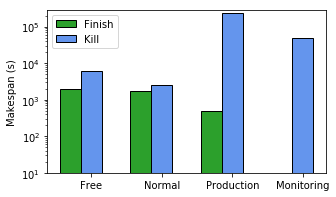

In [165]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_BORDERLINE)
#plt.title('Average makespan for each priority')
ax.set_yscale('log', nonposy='clip')
ax.set_ylabel('Makespan (s)')
plt.xticks(range(4), ['Free', 'Normal', 'Production', 'Monitoring'])

#plt.bar(np.arange(4)-0.3, gprio_makespan_average, yerr=gprio_makespan_std, color='y', width=0.6)
ax.bar(np.arange(4)-0.3, average_all_gprio['Good'], color='tab:green', width=0.3, label='Finish', edgecolor='black')
ax.bar(np.arange(4), average_all_gprio['Bad'], color='cornflowerblue', width=0.3, label='Kill', edgecolor='black')

ax.set_ybound(10)
#plt.legend(loc="right", fontsize='medium')
plt.legend()
#save_fig("makespan_average_finish_kill")
savefig_article(fig, 'makespan_prio_groups.pdf')

In [166]:
average_all_gprio['Good'][2]

493.98602040557023

In [167]:
average_all_gprio['Bad'][2]

229288.96217457953

### Histograms...

In [168]:
makespans_killed = delayed_preproc_df.query(query_type['Bad'])['mt'].compute()

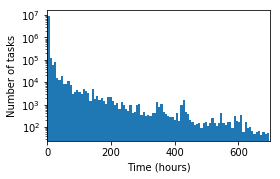

In [175]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_HALF)

#plt.title('Distribution of makespan for killed tasks')
plt.yscale('log', nonposy='clip')
plt.hist(makespans_killed/3600,100)
plt.xlabel('Time (hours)')
plt.ylabel('Number of tasks')
ax.set_xlim(-1,700)
#save_fig("makespan_histo_kill")
savefig_article(fig, 'makespan_histo_killed.pdf')

In [176]:
makespans_finished = delayed_preproc_df.query(query_type['Good'])['mt'].compute()

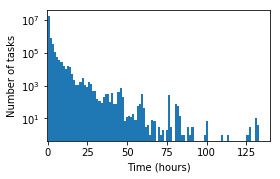

In [182]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_HALF)

#plt.title('Distribution of makespan for killed tasks')
plt.yscale('log', nonposy='clip')
plt.hist(makespans_finished/3600, 100)#, color='tab:orange')
plt.xlabel('Time (hours)')
plt.ylabel('Number of tasks')
ax.set_xlim(-0.5,140)
#save_fig("makespan_histo_kill")
savefig_article(fig, 'makespan_histo_finished.pdf')

# K-means analysis
Clustering of tasks on makespan, prio, sclass.
Using sklearn for several reasons (better tools, results and efficiency).

In [13]:
from numpy import array
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten
import random


from mpl_toolkits.mplot3d import Axes3D

In [14]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [28]:
# adapted for our new pandas based processing and co...
def prepare_data_kmeans(df):
    items = df[['mt', 'prio', 'sclass']].to_numpy()
    stds = np.std(items, 0)    
    
    whiten_items = np.divide(items, stds)
    return (whiten_items, 10, std_items)
    

def do_kmeans_analysis2(k, whiten, good_nb, std_items, postprocess_func=None):
    nbcluster = k
    
    #centroids_whiten, distortion = kmeans(whiten, nbcluster)
    #idx,_ = vq(whiten, centroids_whiten)

    resolv = KMeans(k)
    resolv.fit(whiten)
    idx = resolv.predict(whiten)
    centroids_whiten = resolv.cluster_centers_
    distortion = resolv.score(whiten)
    
    
    # XXX : we suppose the full whiten array is a concatenation of [good, bad] arrays
    goodones = idx[:good_nb]
    badones = idx[good_nb:]
    
    centroids = np.multiply(centroids_whiten, std_items)
    
    print('For {}-means, distortion = {}'.format(k, distortion))
    for c in centroids:
        print('\t centroid : {}'.format(c))
        
    # distribution between the two groups
    print('Rate between Finished ane Killed tasks for the different clusters')
    for i in range(k):
        rate = lambda i, x: (x == i).sum() / float(len(x)) * 100.0
        print('Group {0}  : ({1:.3f}%, {2:.3f}%)'.format(i, rate(i, goodones), rate(i, badones)))


    format_centroid = lambda c: '[makespan {0:.2f}, prio {1:.3f}, sclass {2:.3f}]'.format(*c)
    for i in range(k):
        nb = (idx == i).sum()
        print('Centroid {0}, nb = {1}'.format(format_centroid(centroids[i]), nb))

    if postprocess_func is not None:
        postprocess_func(k, whiten, std_items, resolv)
    
    # TODO here
    return (k, whiten, std_items, resolv)

In [29]:
# almost a copy-past from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def show_silouhette(k, whiten, std_items, resolv, plot_samples=5000, xlim=[-0.05, 1]):
    X = whiten
    n_clusters = k
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    #fig.set_size_inches(18, 7)
    
    plot_samples = len(X) if plot_samples is None else plot_samples

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim(xlim)
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, plot_samples + (n_clusters + 1) * 10])

    clusterer = resolv
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    sample =  np.random.choice(X.shape[0], plot_samples, replace=False)
    print(str(X.shape))
    print(str(sample.shape))
    X_resamp = X[sample]
    cluster_labels = cluster_labels[sample]
    
    silhouette_avg = silhouette_score(X_resamp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_resamp, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
            
        #print(str(ith_cluster_silhouette_values.shape))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.spectral(float(i) / n_clusters)
        color = cm.cividis(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("Silhouette plot for the 4-cluster")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.show()

In [ ]:
def analysis_makespan_clusters(k, whiten, std_items, clusterer):
    data = np.multiply(whiten, std_items) 

    idx = clusterer.fit_predict(whiten)
    
    for i in range(k):
        cluster_data = data[idx == i]
        cluster_makespan = cluster_data[:,0]
        
        avg = np.average(cluster_makespan)
        std = np.std(cluster_makespan)
        median = np.median(cluster_makespan)
        
        print('Cluster {0}: avg={1:.3f}, std={2:.3f}, med={3:.3f}'.format(i, avg, std, median))

In [15]:
partial_data_df = delayed_preproc_df.query('mt > 1')[['mt', 'prio', 'sclass']].compute()

In [16]:
partial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27537704 entries, 0 to 86636
Data columns (total 3 columns):
mt        float32
prio      int8
sclass    int8
dtypes: float32(1), int8(2)
memory usage: 367.7 MB


In [ ]:
whiten_items, osefnb, std_items = prepare_data_kmeans(partial_data_df)

In [24]:
kmeans_2k = do_kmeans_analysis2(2, whiten_items, 100, std_items)

For 2-means, distortion = -57021482.35040033
	 centroid : [4.2331118e+03 5.7103211e-01 6.2133974e-01]
	 centroid : [5.2184551e+03 4.1899371e+00 1.7590263e-01]
Rate between Finished ane Killed tasks for the different clusters
Group 0  : (16.000%, 42.945%)
Group 1  : (84.000%, 57.055%)
Centroid [makespan 4233.11, prio 0.571, sclass 0.621], nb = 11826129
Centroid [makespan 5218.46, prio 4.190, sclass 0.176], nb = 15711575


(27537704, 3)
(20000,)
For n_clusters = 2 The average silhouette_score is : 0.5803761


/home/jupyter/.local/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


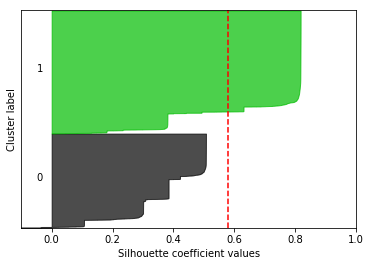

In [26]:
show_silouhette(*kmeans_2k, plot_samples=20000, xlim=[-0.1, 1])

In [32]:
%%time
kmeans_4k = do_kmeans_analysis2(4, whiten_items, 100, std_items)

For 4-means, distortion = -19973578.71183828
	 centroid : [2.6651665e+03 4.1851435e+00 1.6353510e-01]
	 centroid : [9.8951869e+05 7.1818800e+00 1.9555864e+00]
	 centroid : [2.8714651e+03 4.7759688e-01 8.7671867e-03]
	 centroid : [4.9127998e+03 7.2000748e-01 1.7555327e+00]
Rate between Finished ane Killed tasks for the different clusters
Group 0  : (1.000%, 55.813%)
Group 1  : (0.000%, 0.175%)
Group 2  : (83.000%, 28.600%)
Group 3  : (16.000%, 15.412%)
Centroid [makespan 2665.17, prio 4.185, sclass 0.164], nb = 15369444
Centroid [makespan 989518.69, prio 7.182, sclass 1.956], nb = 48209
Centroid [makespan 2871.47, prio 0.478, sclass 0.009], nb = 7875956
Centroid [makespan 4912.80, prio 0.720, sclass 1.756], nb = 4244095
CPU times: user 3min 14s, sys: 1min 10s, total: 4min 24s
Wall time: 4min 2s


(27537704, 3)
(20000,)
For n_clusters = 4 The average silhouette_score is : 0.729311


/home/jupyter/.local/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


CPU times: user 3min 35s, sys: 1min 14s, total: 4min 50s
Wall time: 4min 24s


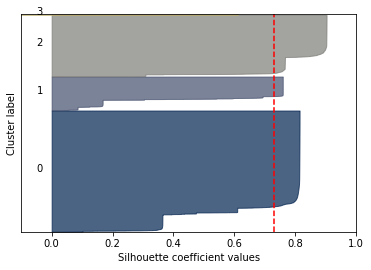

In [34]:
%%time
show_silouhette(*kmeans_4k, plot_samples=20000, xlim=[-0.1, 1])

## Analysis score of different values of k

In [118]:
import time

In [119]:
def kmeans_distortion2(items, nbcluster, nrun = 1):
    all_disp = []
    for i in range(nrun):
        resolv = KMeans(nbcluster)
        resolv.fit(items)
        disp = -resolv.score(items) / len(items)
        #_, disp = kmeans(items, nbcluster)
        all_disp.append(disp)
    return np.mean(disp)

In [ ]:
disp_kmeans = []

In [ ]:
initial_k = 1
# XXX redoing only for k in [9, 12]
initial_k = 9
#(whiten_items, _, _) = prepare_data_kmeans(all_no_diff, all_no_diff_filter)

for k in range(initial_k, 12):
    begin = time.time()
    disp = kmeans_distortion2(whiten_items, k, 1)
    disp_kmeans.append( (k, disp) )
    print(str( (k, disp) ))
    print('For k={}: {} seconds'.format(k, time.time() - begin))

(9, 0.20539546936845243)
For k=9: 483.8541660308838 seconds


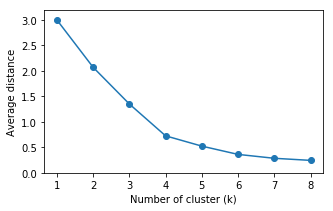

In [123]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE_BORDERLINE)
plt.ylabel('Average distance')
plt.xlabel('Number of cluster (k)')

# TODO : diff entre k et k+1 (% ou value)
# --> justif du choix de k dans le texte

plt.plot(*zip(*disp_kmeans), marker='o', color='tab:blue')
ax.set_ylim(0, 3.2)
#save_fig('distance_cluster')
savefig_article(fig, 'kmeans_distance_clusters.pdf')

In [ ]:
delta_dist = [(k, a-b) for (_, a), (k, b) in zip(disp_kmeans, disp_kmeans[1:])]
delta_dist

## For 2-clustering

In [ ]:
prepared_data = prepare_data_kmeans(all_no_diff, all_no_diff_filter)
kmean_partial = do_kmeans_analysis2(2, *prepared_data)

In [ ]:
show_silouhette(*kmean_partial, plot_samples=20000, xlim=[-0.1, 1])
save_fig('silhouette_2_clustering')

In [ ]:
analysis_makespan_clusters(*kmean_partial)

## For 4-clustering

In [ ]:
prepared_data = prepare_data_kmeans(all_no_diff, all_no_diff_filter)
kmean_partial = do_kmeans_analysis2(4, *prepared_data)

In [ ]:
show_silouhette(*kmean_partial, plot_samples=20000, xlim=[-0.3, 1])
save_fig('silhouette_4_clustering')

In [ ]:
analysis_makespan_clusters(*kmean_partial)

# Read files
and put the data in tasks
tasks : hashtable with 
key (JobID, TaskID)
value : list of [SchedulingClass, Priority, [(event,timestamp) ..]

### Some magic for avoiding re-processing the whole CSV files...
Read pre-processed data for arrival and classification.

In [21]:
def read_from_preprocessed(filename, limit=None):
    tasks_finished = []
    tasks_killed = []
    arrival = []
    
    count = 0
    
    fieldformat = [int, int, int, int, float, float, float]
    row2data = lambda row : (f(v) for f, v in zip(fieldformat, row))
    
    with open(filename, 'r') as f:
        csvfile = csv.reader(f, delimiter=',')
        for row in csvfile:
            lastevt, subtime, sclass, prio, diff, diffrel, mt = row2data(row)
            
            # XXX do not use if arrival time is unknown (before traces begin)
            # rational : make results wrong
            if subtime != 0:
                arrival.append(subtime)
                toadd = (sclass, prio, diff, diffrel, mt)
                if lastevt == 4:
                    tasks_finished.append(toadd)
                elif lastevt == 5:
                    tasks_killed.append(toadd)

                count += 1
                if limit is not None and count > limit:
                    break

    return {'Good' : tasks_finished, 'Bad' : tasks_killed}, arrival

### Playing with Pandas for original GZIP'ed files
The task events table contains the following fields:
1. timestamp
2. missing info
3. job ID
4. task index - within the job
5. machine ID
6. event type
7. user name
8. scheduling class
9. priority
10. resource request for CPU cores
11. resource request for RAM
12. resource request for local disk space
13. different-machine constraint

In [11]:
# we need to take care of the RAM... really...
import gc

In [29]:
original_fields_types = {
    'timestamp': np.uint64,
    'jid': np.int64,
    'tid': np.int32,
    'sclass': np.int8,
    'prio': np.int8,
    'event_type': np.int8,
    'machine_id': np.float64,
}
original_fields = list(original_fields_types.keys())

all_fields = ['timestamp', 'missing_info', 'jid', 'tid', 'machine_id', 'event_type', 'user_name', 'sclass', 'prio', 'req_cpu', 'req_ram', 'req_disk', 'machine_constraints']

In [26]:
list(map(lambda x: x in all_fields, original_fields))

[True, True, True, True, True, True, True]

In [30]:
%%time
tdf = pd.read_csv(tasksFiles[0], header=None, names=all_fields, usecols=original_fields, dtype=original_fields_types, nrows=None, low_memory=True)

CPU times: user 747 ms, sys: 10.4 ms, total: 757 ms
Wall time: 757 ms


In [24]:
tdf.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450146 entries, 0 to 450145
Data columns (total 7 columns):
timestamp     450146 non-null uint64
jid           450146 non-null int64
tid           450146 non-null int32
machine_id    330581 non-null object
event_type    450146 non-null int8
sclass        450146 non-null int8
prio          450146 non-null int8
dtypes: int32(1), int64(1), int8(3), object(1), uint64(1)
memory usage: 34.2 MB


In [115]:
#del preproc_df
gc.collect()

0

In [105]:
len(tdf.groupby(['jid', 'tid']))

190926

In [20]:
for row in tdf.iterrows():
    print(row)
    break

(0, timestamp     0.000000e+00
jid           3.418309e+06
tid           0.000000e+00
machine_id    4.155527e+09
event_type    0.000000e+00
sclass        3.000000e+00
prio          9.000000e+00
Name: 0, dtype: float64)


### And now with Dask (?)

In [31]:
test = daskdf.read_csv('clusterdata-2011-2/task_events/part-00*-of-00500.csv.gz', compression='gzip', header=None, names=all_fields, usecols=original_fields, dtype=original_fields_types, nrows=None, low_memory=True)

/home/jupyter/.local/lib/python3.5/site-packages/dask/dataframe/io/csv.py:318: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression)


In [33]:
%%time
all_mids = test['machine_id'].unique().compute()

CPU times: user 6min 40s, sys: 33.3 s, total: 7min 14s
Wall time: 2min 18s


In [35]:
len(all_mids)

12586

In [88]:
%%time
test['timestamp'].max().compute()

CPU times: user 1min 2s, sys: 4.7 s, total: 1min 6s
Wall time: 21.3 s


18446744073709551615

In [92]:
np.uint64(2**64-1)

18446744073709551615

In [70]:
%%time
a = test.groupby(['jid', 'tid'])['event_type'].count().describe().compute()

CPU times: user 1min 42s, sys: 10.8 s, total: 1min 53s
Wall time: 38.5 s


In [71]:
a

count    5.075073e+06
mean     6.494353e+00
std      1.141031e+02
min      1.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      3.000000e+00
max      4.556900e+04
dtype: float64

In [107]:
daskdf.to_parquet(test.query('event_type == 0')[['jid', 'tid', 'sclass', 'prio', 'timestamp']], 'initial_event_preproc.prq')

In [112]:
testparquet = daskdf.read_parquet('initial_event_preproc.prq')#, dtype=original_fields_types)

In [115]:
testparquet.head()

,jid,tid,sclass,prio,timestamp
0,3418309,0,3,9,0
1,3418309,1,3,9,0
2,3418314,0,3,9,0
3,3418314,1,3,9,0
4,3418319,0,3,9,0


In [94]:
%%time
occurences_event_number = test.groupby(['jid', 'tid'])['event_type'].count().value_counts().compute()

CPU times: user 7min 39s, sys: 37.1 s, total: 8min 16s
Wall time: 2min 45s


In [102]:
np.uint64(2**63-1) - (1000*1000*29*3600*24)

9.223369531254776e+18

In [84]:
(1000*1000*29*3600*24)

2505600000000

In [101]:
devents = dict(occurences_event_number)
pd.DataFrame([{**{k: devents.get(k, 0) for k in range(1, 6)}, '6+': sum(devents.get(k, 0) for k in devents.keys() if k >= 6), 'total': sum(devents.values())}])

,1,2,3,4,5,6+,total
0,198,872310,22069712,13356,106228,2362927,25424731


In [97]:
print(sum(devents.values()))

25424731


In [226]:
test2 = test.tail(1000)#.iloc[10000:15000]

In [284]:
tgb = test2.groupby('jid')

In [320]:
for name, group in tgb:
    for tid, subgroup in group.groupby('tid'):
        print(name)
        print(subgroup.timestamp)
    break

515042954
449151    5553800414
449152    5553800417
Name: timestamp, dtype: int64
515042954
449156    5553800648
449157    5553800651
Name: timestamp, dtype: int64
515042954
449160    5553800854
449161    5553800857
Name: timestamp, dtype: int64
515042954
449166    5553800999
449167    5553801002
Name: timestamp, dtype: int64
515042954
449170    5553801041
449171    5553801044
Name: timestamp, dtype: int64
515042954
449172    5553801054
449173    5553801057
Name: timestamp, dtype: int64


In [130]:
for a in test.iterrows():
    print(a)
    break

(0, timestamp           0
jid           3418309
tid                 0
event_type          0
sclass              3
prio                9
Name: 0, dtype: int64)


In [300]:
prototype = {
    #'tid': np.int32,
    'submission': np.int64,
    'nb_events': np.int8,
    'last_event': np.int8,
    'duration': np.float32,
    'sclass': np.int8,
    'prio': np.int8,
}

In [301]:
#fuuu = pd.Series({'submission': 0, 'nb_events': 100, 'last_event': 0, 'duration': 0, 'sclass': 0, 'prio': 0})
#fuuu
#.astype(prototype)

In [321]:
def aggregtasks(full_partition):
    global prototype
    
    submissions = []
    nb_eventses = []
    last_events = []
    durations = []
    sclasses = []
    prios = []
    tids = []
    
    full_partition = full_partition.copy()
    
    for tid, partition in full_partition.groupby('tid'):
    
        initial = partition.loc[partition.event_type == 0]
        nb_events = len(partition)
        sclasses.append(partition.iloc[0].sclass)
        prios.append(partition.iloc[0].prio)
        tids.append(tid)
        
        if len(initial) == 1 and initial.iloc[0].timestamp > 0:
            initial = initial.iloc[0]

            #for row in partition:
            #    timestamp = row.timestamp
            #    evtType = row.event_type

            last = partition.loc[partition.timestamp.idxmax()]
            last_event = last.event_type
            # XXX maybe improve with only finishing events?
            duration = last.timestamp - initial.timestamp
            
            submissions.append(initial.timestamp)
            nb_eventses.append(nb_events)
            last_events.append(last_event)
            durations.append(duration)
            
        else:
            submissions.append(0)
            nb_eventses.append(nb_events)
            last_events.append(0)
            durations.append(0)
            
    return pd.DataFrame({'submission': submissions, 'nb_events': nb_eventses,
                              'last_event': last_events, 'duration': durations, 'sclass': sclasses, 'prio': prios}, index=tids).astype(prototype)

In [322]:
protobis = pd.Series(prototype)
#protobis.astype()

In [323]:
myagg = test.groupby('jid').apply(aggregtasks, meta=prototype)#, meta=(names, dtypes))

In [324]:
%%time
tmpret = myagg.compute()

CPU times: user 7min 55s, sys: 20.8 s, total: 8min 16s
Wall time: 7min 52s


In [325]:
tmpret.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 190926 entries, (3418309, 0) to (6252020683, 0)
Data columns (total 6 columns):
duration      190926 non-null float32
last_event    190926 non-null int8
nb_events     190926 non-null int8
prio          190926 non-null int8
sclass        190926 non-null int8
submission    190926 non-null int64
dtypes: float32(1), int64(1), int8(4)
memory usage: 3.8 MB


In [327]:
tmpret.tail()
tmpret.nb_events.describe()

count    190926.000000
mean          2.282612
std           0.900540
min        -112.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          71.000000
Name: nb_events, dtype: float64

## Legacy code, memory-hungry (~32Go at least)

In [29]:
import gzip
import sys

def read_tasks(tasksFiles):
    tasks={}
    bad_tasks=[]
    arrival=[]
    current_time=0

    for f in tasksFiles:
        print('File: {}'.format(f))
        with gzip.open(f, 'rt') as f:
            for line in f.readlines():
                (timestamp,_,jID,tID,_,evtType,_,schedClass,prio,_,_,_,_)=line.split(',')
                try:
                    if(evtType == '0'):
                        timestamp=int(timestamp)
                        tasks[(int(jID), int(tID))] = (int(schedClass), int(prio), [(0,int(timestamp))])
                        if timestamp>0:
                            arrival.append(timestamp-current_time)
                            current_time=timestamp
                    else:
                        (_,_, events)=tasks[(int(jID),int(tID))]
                        events.append((int(evtType),int(timestamp)))
                except:
                    bad_tasks.append((int(jID), int(tID)))
            print("Bad {}".format(len(bad_tasks)))
            print("Good {}".format(len(tasks)))
    return arrival,tasks

In [ ]:
arrival_time, tasks = read_tasks(tasksFiles)
print('Finished')

File: clusterdata-2011-2/task_events/part-00000-of-00500.csv.gz
Bad 0
Good 190926
File: clusterdata-2011-2/task_events/part-00001-of-00500.csv.gz
Bad 0
Good 208329
File: clusterdata-2011-2/task_events/part-00002-of-00500.csv.gz
Bad 0
Good 243512
File: clusterdata-2011-2/task_events/part-00003-of-00500.csv.gz
Bad 0
Good 274536
File: clusterdata-2011-2/task_events/part-00004-of-00500.csv.gz
Bad 0
Good 304279
File: clusterdata-2011-2/task_events/part-00005-of-00500.csv.gz
Bad 0
Good 345562
File: clusterdata-2011-2/task_events/part-00006-of-00500.csv.gz
Bad 0
Good 371702
File: clusterdata-2011-2/task_events/part-00007-of-00500.csv.gz
Bad 0
Good 399959
File: clusterdata-2011-2/task_events/part-00008-of-00500.csv.gz
Bad 0
Good 414594
File: clusterdata-2011-2/task_events/part-00009-of-00500.csv.gz
Bad 0
Good 464004
File: clusterdata-2011-2/task_events/part-00010-of-00500.csv.gz
Bad 0
Good 500585
File: clusterdata-2011-2/task_events/part-00011-of-00500.csv.gz
Bad 0
Good 541186
File: clusterdat

# Content
Look at the number of event per task, and of events that are incomplete and of the ending type of events finishsing

In [8]:
def tasks_stats(tasks):
    l=defaultdict(int)
    bad=0
    last_event=defaultdict(int)
    for i in tasks:
        evts=tasks[i][2]
        li=len(evts)
        l[li]=l[li]+1
        if li==3:
            if evts[0][0] != 0 or evts[1][0]!= 1:
                bad=bad+1
            last_event[evts[2][0]]=last_event[evts[2][0]]+1
    return (dict(l),dict(last_event), bad)

l, last, bad = tasks_stats(tasks)
print('Number of events', l, 'Total :', len(tasks))
print('Number of bad events', bad)
print('Final events for three events', last)


Number of events {1: 248, 2: 1093992, 3: 24258907, 4: 19378, 5: 17215, 6: 8510, 7: 5093, 8: 3028, 9: 4024, 10: 1364, 11: 1099, 12: 898, 13: 1375, 14: 550, 15: 1093, 16: 1417, 17: 755, 18: 1570, 19: 492, 20: 635, 21: 274, 22: 141, 23: 358, 24: 118, 25: 127, 26: 76, 27: 30, 28: 8, 29: 7, 30: 13, 32: 2, 33: 1182, 34: 11, 35: 2, 36: 34, 37: 34, 38: 67, 39: 77, 40: 169, 41: 116, 42: 108, 43: 96, 44: 23, 45: 13, 46: 1, 53: 1} Total : 25424731
Number of bad events 179
Final events for three events {1: 2, 2: 8626, 3: 86348, 4: 17775284, 5: 6381906, 6: 5102, 8: 1639}


## Table 1 : Distribution of number of events per task

In [9]:
neuf=0
for key, value in l.items():
    if key>8:
        neuf+=value
for key,value in l.items():
    if (key<9):
        print key,":",value
print '+ 9 :',neuf

1 : 248
2 : 1093992
3 : 24258907
4 : 19378
5 : 17215
6 : 8510
7 : 5093
8 : 3028
+ 9 : 18360


## Table II : Distribution of finishing event for all tasks with three events

In [10]:
d_events_type={}
d_events_type["finish"]=0
d_events_type["kill"]=0
d_events_type["fail"]=0
d_events_type["other"]=0
d_events_type["total"]=0

for key,value in last.items():
    if (key==1):
        d_events_type["other"]+=value
    if (key==2):
        d_events_type["other"]+=value
    if (key==3):
        d_events_type["fail"]+=value
    if (key==4):
        d_events_type["finish"]+=value
    if (key==5):
        d_events_type["kill"]+=value
    if (key==6):
        d_events_type["other"]+=value
    if (key==8):
        d_events_type["other"]+=value
    d_events_type["total"]+=value
print 'NUMBER'
print d_events_type
total = d_events_type["total"]
print 'PERCENTAGE'
for key,value in d_events_type.items():
    res = float(value*100)
    res= float(res/total)
    print key,res

NUMBER
{'fail': 86348, 'total': 24258907, 'finish': 17775284, 'kill': 6381906, 'other': 15369}
PERCENTAGE
fail 0.355943489128
total 100.0
finish 73.2732270254
kill 26.3074754357
other 0.0633540497105


In [11]:
print 'Dans le cas des 500 fichiers :'
print 'Number of events {1: 248, 2: 1093992, 3: 24258907, 4: 19378, 5: 17215, 6: 8510, 7: 5093, 8: 3028, 9: 4024, 10: 1364, 11: 1099, 12: 898, 13: 1375, 14: 550, 15: 1093, 16: 1417, 17: 755, 18: 1570, 19: 492, 20: 635, 21: 274, 22: 141, 23: 358, 24: 118, 25: 127, 26: 76, 27: 30, 28: 8, 29: 7, 30: 13, 32: 2, 33: 1182, 34: 11, 35: 2, 36: 34, 37: 34, 38: 67, 39: 77, 40: 169, 41: 116, 42: 108, 43: 96, 44: 23, 45: 13, 46: 1, 53: 1} Total : 25424731'
print 'Number of bad events 179'
print 'Final events for three events {1: 2, 2: 8626, 3: 86348, 4: 17775284, 5: 6381906, 6: 5102, 8: 1639}'

Dans le cas des 500 fichiers :
Number of events {1: 248, 2: 1093992, 3: 24258907, 4: 19378, 5: 17215, 6: 8510, 7: 5093, 8: 3028, 9: 4024, 10: 1364, 11: 1099, 12: 898, 13: 1375, 14: 550, 15: 1093, 16: 1417, 17: 755, 18: 1570, 19: 492, 20: 635, 21: 274, 22: 141, 23: 358, 24: 118, 25: 127, 26: 76, 27: 30, 28: 8, 29: 7, 30: 13, 32: 2, 33: 1182, 34: 11, 35: 2, 36: 34, 37: 34, 38: 67, 39: 77, 40: 169, 41: 116, 42: 108, 43: 96, 44: 23, 45: 13, 46: 1, 53: 1} Total : 25424731
Number of bad events 179
Final events for three events {1: 2, 2: 8626, 3: 86348, 4: 17775284, 5: 6381906, 6: 5102, 8: 1639}


# Wating time
Waiting time
- First graph is absolute waiting time in seconds
- Second graph is relative waiting time to the lenght of the task

In [12]:
def analyse_tasks(tasks):
    waiting_time={'Good':[], 'Bad':[]}
    relative_waiting_time={'Good':[], 'Bad':[]}
    makespan={'Good':[], 'Bad':[]}
    classification = {'Good':[], 'Bad':[]}
    submass_={'Good':defaultdict(int), 'Bad':defaultdict(int)}
    realmass_={'Good':defaultdict(int), 'Bad':defaultdict(int)}

    for t in tasks:
        sclass, prio, evts=tasks[t]
        if len(evts)>=3 and (evts[-1][0] == 4 or evts[-1][0] == 5):
            subtime=evts[0][1]
            runtime=evts[1][1]
            endtime=evts[2][1]
            diff=runtime-subtime
            diffrel=diff/float(endtime-runtime)
            mt=float(endtime-runtime)/1000000.0
            tmp = (sclass, prio, float(diff)/1000000, diffrel, mt)
            status='Good'
            if evts[-1][0]== 5 :
                status='Bad'
            waiting_time[status].append(float(diff)/1000000.0)
            relative_waiting_time[status].append(diffrel)
            makespan[status].append(mt)
            classification[status].append(tmp)
            submass_[status][subtime] += 1
            submass_[status][subtime+endtime-runtime] -=1

            realmass_[status][runtime] += 1
            realmass_[status][endtime] -= 1
    return waiting_time, relative_waiting_time, makespan, classification, submass_, realmass_

waiting_time, relative_waiting_time, makespan, classification, submass_, realmass_=analyse_tasks(tasks)
tasks=[]
print 'Les taches qui finissent bien', len(makespan['Good']), 'Total :', sum(makespan['Good']), 'Mean', sum(makespan['Good'])/float(len(makespan['Good']))
print 'Les taches qui finissent mal ', len(makespan['Bad']), 'Total :', sum(makespan['Bad']), 'Mean', sum(makespan['Bad'])/float(len(makespan['Bad']))


Les taches qui finissent bien 17807965 Total : 30159205857.8 Mean 1693.57957845
Les taches qui finissent mal  6419660 Total : 51320980647.2 Mean 7994.34559575


# Test : log normal distribution - pareto 

In [13]:
import scipy.stats

for t in ['Good', 'Bad']:
    print("## Makespan stats for {} tasks".format(t))

    for dist_name in ['lognorm', 'pareto']:
        d = getattr(scipy.stats, dist_name)

        param = d.fit(makespan[t], floc=0)
        print("Fit params for {} : {}".format(dist_name, param))
        cdf =  lambda x: d.cdf(x, *param[:-2], loc=param[-2], scale=param[-1])

        ks = scipy.stats.kstest(makespan[t], cdf)
        print("KS test for {} : {}".format(dist_name, ks))

## Makespan stats for Good tasks
Fit params for lognorm : (1.4212266630988188, 0, 517.69627936618781)
KS test for lognorm : (0.056843361118668223, 0.0)


/usr/lib/python2.7/dist-packages/scipy/stats/distributions.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fit params for pareto : (0.11286526232991492, 0, 0.073068999993754338)
KS test for pareto : (0.50199217569709587, 0.0)
## Makespan stats for Bad tasks
Fit params for lognorm : (2.0564740975503595, 0, 463.99375773325403)
KS test for lognorm : (0.064233134133444392, 0.0)
Fit params for pareto : (0.091550438630806197, 0, 0.0077039999987571512)
KS test for pareto : (0.48754334039537983, 0.0)


# Stats

In [14]:
print 'sc, prio, diff, diffrel, makespan'
print classification['Good'][:10]

sc, prio, diff, diffrel, makespan
[(1, 2, 2.469383, 0.0001874781410543501, 13171.578223), (0, 4, 1.290144, 0.0027936464810472826, 461.813622), (0, 0, 2.396646, 0.022818108131992577, 105.032634), (0, 4, 4.663145, 0.006099350035643138, 764.531462), (0, 0, 1.336107, 0.005289367294432614, 252.602424), (0, 4, 1.503338, 0.0023671063103712876, 635.095261), (0, 4, 31.370127, 0.006090222596532824, 5150.899906), (0, 4, 2.001668, 0.010291355836007984, 194.499931), (0, 6, 4.926309, 0.030516940718056485, 161.428665), (1, 4, 1.13914, 0.0018454203207303387, 617.279428)]


# classes & prio

In [15]:
def qual(data):
    scl=[0]*4
    priol=[0]*13
    for (sc, prio, diff, diffrel, makespan) in data:
        scl[int(sc)] += 1
        priol[int(prio)] += 1
    return scl, priol

(sclGood, prioGood) = qual(classification['Good'])
print 'Good'
print 'Schedulin Classes' , sclGood
print 'Priorities', prioGood

(sclBad, prioBad) = qual(classification['Bad'])
print 'Bad'
print 'Schedulin Classes' , sclBad
print 'Priorities', prioBad

scl={'Good':sclGood,'Bad':sclBad}
prio={'Good':prioGood,'Bad':prioBad}

Good
Schedulin Classes [14901940, 2738022, 167943, 60]
Priorities [3439929, 1641846, 986540, 982, 11076548, 104, 498723, 0, 114103, 49190, 0, 0, 0]
Bad
Schedulin Classes [5415458, 589261, 365387, 49554]
Priorities [2261617, 715428, 91936, 45, 2898530, 0, 134722, 0, 135829, 180974, 579, 0, 0]


## Relation between priority and scheduling class

In [16]:
prio_sclasses = {}
priogroup_sclasses = {}

def classify_prio_sclasses(name, classif):
    sclasses_grouped = []
    prio_groups = [range(0, 2), range(2, 9), [9, 11], [10]]
    sclasses_prio = [ 12*[0] for x in range(4) ]
    
    for t in classif:
        sclasses_prio[t[0]][t[1]] += 1
        
    # normalization
    sclasses_count = 4*[0]
    for i in range(4):
        count = sum(sclasses_prio[i])
        sclasses_count[i] = count
        #print("sclass {} : {} tasks".format(i, count))
        if count != 0:
            sclasses_prio[i] = [ sclasses_prio[i][j] / float(count) for j in range(12)]
    
    # priority groups
    for i in range(4):
        sclass = []
        for group in prio_groups:
            groupsum = 0.0
            for j in group:
                groupsum += sclasses_prio[i][j]
            sclass.append(groupsum)
        sclasses_grouped.append(sclass)

    global prio_sclasses
    global priogroup_sclasses
    prio_sclasses[name] = sclasses_prio
    priogroup_sclasses[name] = sclasses_grouped
    

In [17]:
classify_prio_sclasses('Good', classification['Good'])
classify_prio_sclasses('Bad', classification['Bad'])
classify_prio_sclasses('All', classification['Bad'] + classification['Good'])

sclasses_colors = ['green', 'greenyellow', 'orange', 'red']

### For 'good' tasks

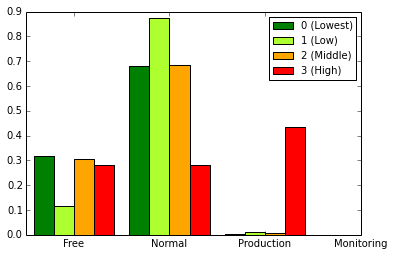

In [18]:
fig, ax = plt.subplots()
#fig.set_size_inches(10.0, 5.0)
#plt.title('Distribution of priority groups for each scheduling class for finishing tasks')

ind = np.arange(4)
width = 0.21
rects = []
for i in range(4):
    rects.append(ax.bar(ind + (i-2)*width, priogroup_sclasses['Good'][i], width=width, color=sclasses_colors[i]))

ax.set_xticks(ind)
ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'),fontsize='medium')
save_fig("distrib_sclass_prio_finish")

### For 'bad' tasks (services)

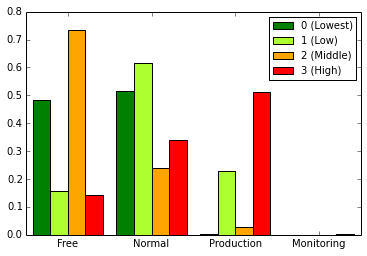

In [19]:
fig, ax = plt.subplots()


ind = np.arange(4)
width = 0.21
rects = []
for i in range(4):
    rects.append(ax.bar(ind + (i-2)*width, priogroup_sclasses['Bad'][i], width=width, color=sclasses_colors[i]))

ax.set_xticks(ind)
ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
#ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'), loc="right")
ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'), fontsize='medium')

save_fig("distrib_sclass_prio_killed")

### For all tasks

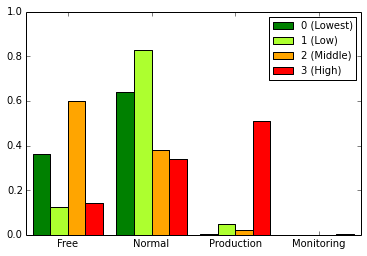

In [20]:
fig, ax = plt.subplots()
#fig.set_size_inches(10.0, 5.0)
#plt.title('Distribution of task priority among each scheduling class')

ind = np.arange(4)
width = 0.21
rects = []
for i in range(4):
    rects.append(ax.bar(ind + (i-2)*width, priogroup_sclasses['All'][i], width=width, color=sclasses_colors[i]))

ax.set_ybound(0, 1)
ax.set_xticks(ind)
ax.set_xticklabels(['Free', 'Normal', 'Production', 'Monitoring'])
ax.legend(tuple([rect[0] for rect in rects]), ('0 (Lowest)', '1 (Low)', '2 (Middle)', '3 (High)'),fontsize='medium')
save_fig("distrib_sclass_prio")

## Makespan stats for tasks and services

In [21]:
def priogroup_makespan_stats(classif):
    # 12 priority levels
    prio_makespan = [[] for _ in range(12)]

    for t in classif:
        prio_makespan[t[1]].append(t[4])

    # stats
    prio_makespan_average = [np.average(m) for m in prio_makespan]
    prio_makespan_std = [np.std(m) for m in prio_makespan]
    prio_makespan_median = [np.median(m) for m in prio_makespan]

    # stats for priority groups
    pm = prio_makespan
    gprio_makespan = [pm[0] + pm[1], pm[2] + pm[3] + pm[4] + pm[5] + pm[6] + pm[7] + pm[8], pm[9] + pm[11], pm[10]]

    gprio_makespan_average = [np.average(m) for m in gprio_makespan]
    gprio_makespan_std = [np.std(m) for m in gprio_makespan]
    gprio_makespan_median = [np.median(m) for m in gprio_makespan]

    # stats for ALL tasks
    am = []
    for m in pm:
        am += m
    all_stats = [len(am), np.average(am), np.std(am), np.median(am)]
    #print("All : {}".format(all_stats))

    #print("Task number for each priority group : {}".format([len(m) for m in gprio_makespan]))
    #print("Task makespan mean for each priority group : {}".format(gprio_makespan_average))
    #print("Task makespan median for each priority group : {}".format(gprio_makespan_median))
    #print("Task makespan std dev for each priority group : {}".format(gprio_makespan_std))
    
    ret = {}
    for pgroup in [('Free', 0), ('Normal', 1), ('Production', 2), ('Monitoring', 3), ('All', -1)]:
        tmp = {}
        if pgroup[1] >= 0:
            tmp['count'] = len(gprio_makespan[pgroup[1]])
            tmp['avg'] = gprio_makespan_average[pgroup[1]]
            tmp['std'] = gprio_makespan_std[pgroup[1]]
            tmp['med'] = gprio_makespan_median[pgroup[1]]
        else:
            # all
            tmp['count'] = all_stats[0]
            tmp['avg'] = all_stats[1]
            tmp['std'] = all_stats[2]
            tmp['med'] = all_stats[3]
        ret[pgroup[0]] = tmp
        
    return ret





In [22]:
priogroup_makespan = {}
priogroup_makespan['Good'] = priogroup_makespan_stats(classification['Good'])
priogroup_makespan['Bad'] = priogroup_makespan_stats(classification['Bad'])

print("All statistics for both Tasks and Services (table VI and VII) :")
print(str(priogroup_makespan))

/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:91: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:113: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


All statistics for both Tasks and Services (table VI and VII) :
{'Bad': {'All': {'count': 6419660, 'std': 59363.797782965485, 'avg': 7994.3455957533452, 'med': 333.82506899999998}, 'Production': {'count': 180974, 'std': 294182.35499764903, 'avg': 148424.38833104685, 'med': 31429.425025500001}, 'Monitoring': {'count': 579, 'std': 579101.91805430409, 'avg': 388232.54421172565, 'med': 71831.589154999994}, 'Free': {'count': 2977045, 'std': 24336.442485204927, 'avg': 5195.6308373594229, 'med': 595.42672900000002}, 'Normal': {'count': 3261062, 'std': 19468.978667944168, 'avg': 2688.5756677143754, 'med': 213.9071375}}, 'Good': {'All': {'count': 17807965, 'std': 5034.5250872828892, 'avg': 1693.5795784507297, 'med': 448.90721300000001}, 'Production': {'count': 49190, 'std': 1955.1163226978615, 'avg': 493.89708989109852, 'med': 39.124604500000004}, 'Monitoring': {'count': 0, 'std': nan, 'avg': nan, 'med': nan}, 'Free': {'count': 5081775, 'std': 4518.6755414386571, 'avg': 1937.9013453466578, 'med

In [23]:
# Prepare only the average for next figure (reversed classification)
average_all_gprio = {}

for etype in ['Good', 'Bad']:
    tmp = []
    for g in ['Free', 'Normal', 'Production', 'Monitoring']:
        tmp.append(priogroup_makespan[etype][g]['avg'])
    average_all_gprio[etype] = tmp

/usr/lib/pymodules/python2.7/matplotlib/scale.py:97: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


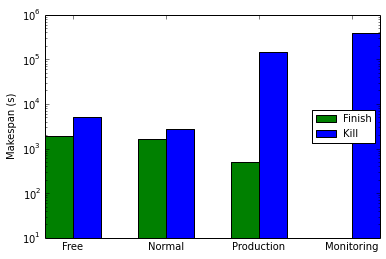

In [24]:
fig, ax = plt.subplots()
#plt.title('Average makespan for each priority')
ax.set_yscale('log', nonposy='clip')
ax.set_ylabel('Makespan (s)')
plt.xticks(range(4), ['Free', 'Normal', 'Production', 'Monitoring'])

#plt.bar(np.arange(4)-0.3, gprio_makespan_average, yerr=gprio_makespan_std, color='y', width=0.6)
ax.bar(np.arange(4)-0.3, average_all_gprio['Good'], color='g', width=0.3, label='Finish')
ax.bar(np.arange(4), average_all_gprio['Bad'], color='b', width=0.3, label='Kill')

ax.set_ybound(10)
plt.legend(loc="right", fontsize='medium')
save_fig("makespan_average_finish_kill")

# Histograms of makespan for both Good/Bad


In [25]:
makespans = {}

for etype in ['Good', 'Bad']:
    temp = []
    for t in classification[etype]:
        temp.append(t[4])
    makespans[etype] = temp
    print(len(temp))

17807965
6419660


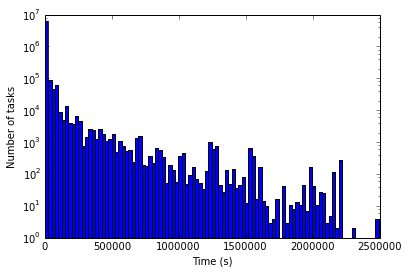

In [26]:
plt.figure()

#plt.title('Distribution of makespan for killed tasks')
plt.yscale('log', nonposy='clip')
plt.hist(makespans['Bad'],100)
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
save_fig("makespan_histo_kill")

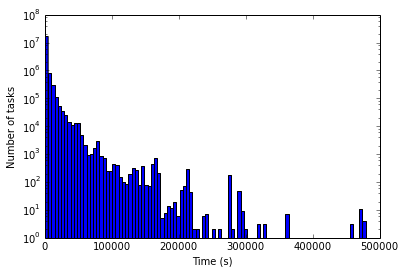

In [27]:
plt.figure()

#plt.title('Distribution of makespan for finished tasks')
plt.yscale('log', nonposy='clip')
plt.hist(makespans['Good'],100)
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
save_fig("makespan_histo_finish")

# Arrival time

Interarrival time : mean=0.05196260895,median=2e-06
[600.047726, 0.771533, 2.489368, 0.737554, 9.9e-05, 0.0002, 1.2e-05, 8.7e-05, 1.540691, 0.000363]
finished


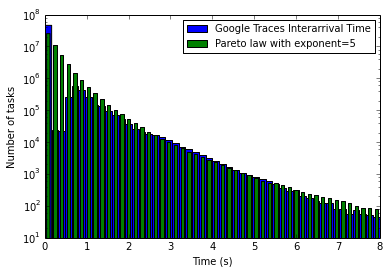

In [37]:
arrival_delta = map(lambda x: float(x)/1000000, arrival_time)
print arrival_delta[:10] 
print("Interarrival time : mean={},median={}".format(np.mean(arrival_delta), np.median(arrival_delta)))


import numpy as np
from scipy.stats import kstest
import scipy as sc

#print kstest(arrival_delta, 'expon')

#(b,loc, scale) = sc.stats.pareto.fit(arrival_delta, .7)
print 'finished'
images_path ="figures_res/"

#fig, ax = plt.subplots(1, 1)
#print (b,loc, scale)

fig, ax = plt.subplots()
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
plt.yscale('log', nonposy='clip')
vals = sc.stats.pareto.rvs(5,  size=len(arrival_time))

v1=[x for x in arrival_delta if x < 8]
v2=[x-1 for x in vals if x < 9]

#_=plt.hist([v1,v2],100)

ax.hist(v1, 50)
ax.hist(v2, 50, rwidth=.5)
#title='Distribution of inter-arrival time'
ax.legend(['Google Traces Interarrival Time','Pareto law with exponent=5'],fontsize='medium')
save_fig('interarrival')
#plt.title('Distribution of inter-arrival time')


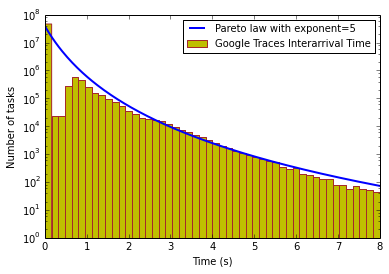

In [29]:

fig, ax = plt.subplots()
plt.xlabel('Time (s)')
plt.ylabel('Number of tasks')
plt.yscale('log', nonposy='clip')
vals = sc.stats.pareto.rvs(5,  size=len(arrival_time))

v1=[x for x in arrival_delta if x < 8]
v2=[x-1 for x in vals if x < 9]

nbbins = 50.0
xlim = 8.0

x = np.linspace(0.01, 8, 200)
factor = len(v1) * (xlim/nbbins)
pareto_model = sc.stats.pareto.pdf(x, 5, loc=-1) * factor

#_=plt.hist([v1,v2],100)

ax.hist(v1, 50, color='y', edgecolor='brown', label='Google Traces Interarrival Time')
ax.plot(x, pareto_model, color='b', label='Pareto law with exponent=5', linewidth=2)

ax.set_ybound(lower=1)

#ax.hist(v2, 50, rwidth=.5)
#title='Distribution of inter-arrival time'
ax.legend(fontsize='medium')
save_fig('interarrival_plot')
#plt.title('Distribution of inter-arrival time')


# Tables



In [30]:
def tasks_stats(tasks):
    l=defaultdict(int)
    bad=0
    last_event=defaultdict(int)
    for i in tasks:
        evts=tasks[i][2]
        li=len(evts)
        l[li]=l[li]+1
        if li==3:
            if evts[0][0] != 0 or evts[1][0]!= 1:
                bad=bad+1
            last_event[evts[2][0]]=last_event[evts[2][0]]+1
    return (dict(l),dict(last_event), bad)

l, last, bad = tasks_stats(tasks)
print 'Number of events', l, 'Total :', len(tasks)
print 'Number of bad events', bad
print 'Final events for three events', last

Number of events {} Total : 0
Number of bad events 0
Final events for three events {}


## Table III : Number of tasks and frequency for each scheduling class

In [31]:
sclTotal = []
for i in range(len(sclGood)):
    sclTotal.append(sclGood[i] + sclBad[i]) 
    
sclTotalPercentage = [float(x) * 100.0 / sum(sclTotal) for x in sclTotal]

print(sclTotal)
print(sclTotalPercentage)

[20317398, 3327283, 533330, 49614]
[83.86046094076494, 13.733426202527074, 2.201330093230352, 0.20478276347764174]


## Table IV : Number of tasks for each priority level

In [32]:
prioTotal = []
for i in range(len(prioGood)):
    prioTotal.append(prioGood[i] + prioBad[i]) 

print(prioTotal)

[5701546, 2357274, 1078476, 1027, 13975078, 104, 633445, 0, 249932, 230164, 579, 0, 0]


## Table V : Number of tasks and frequency for the four priority groups

In [33]:
prio_groups = [range(0, 2), range(2, 9), [9, 11], [10]]
    
# priority groups
prioGroupsTotal = []
for group in prio_groups:
    groupsum = 0
    for j in group:
        groupsum += prioGood[j] + prioBad[j]
    prioGroupsTotal.append(groupsum)

prioGroupsPercentage = [float(x) * 100.0 / sum(prioGroupsTotal) for x in prioGroupsTotal]
    
print(prioGroupsTotal)
print(prioGroupsPercentage)

[8058820, 15938062, 230164, 579]
[33.26293848447795, 65.78466523235356, 0.9500064492495653, 0.002389833918925194]


## Table VI : Statistics for execution time of task finsihed by a Finish event 

In [34]:
# 12 priority levels
prio_makespan = [[] for _ in range(12)]

for t in classification['Good']:
    prio_makespan[t[1]].append(t[4])

# stats
prio_makespan_average = [np.average(m) for m in prio_makespan]
prio_makespan_std = [np.std(m) for m in prio_makespan]
prio_makespan_median = [np.median(m) for m in prio_makespan]

pm = prio_makespan
gprio_makespan = [pm[0] + pm[1], pm[2] + pm[3] + pm[4] + pm[5] + pm[6] + pm[7] + pm[8], pm[9] + pm[11], pm[10]]

gprio_makespan_average = [np.average(m) for m in gprio_makespan]
gprio_makespan_std = [np.std(m) for m in gprio_makespan]
gprio_makespan_median = [np.median(m) for m in gprio_makespan]


am = []
for m in pm:
    am += m
all_stats = [len(am), np.average(am), np.std(am), np.median(am)]
print("All : {}".format(all_stats))

print("Task number for each priority group : {}".format([len(m) for m in gprio_makespan]))
print("Task makespan mean for each priority group : {}".format(gprio_makespan_average))
print("Task makespan median for each priority group : {}".format(gprio_makespan_median))
print("Task makespan std dev for each priority group : {}".format(gprio_makespan_std))


All : [17807965, 1693.5795784507297, 5034.5250872828892, 448.90721300000001]
Task number for each priority group : [5081775, 12677000, 49190, 0]
Task makespan mean for each priority group : [1937.9013453466578, 1600.2944269675959, 493.89708989109852, nan]
Task makespan median for each priority group : [345.790075, 492.56216949999998, 39.124604500000004, nan]
Task makespan std dev for each priority group : [4518.6755414386571, 5231.3686295941561, 1955.1163226978615, nan]


## Table VII : Statistics for execution time of tasks finished by a Kill event

In [35]:
# 12 priority levels
prio_makespan = [[] for _ in range(12)]

for t in classification['Bad']:
    prio_makespan[t[1]].append(t[4])

# stats
prio_makespan_average = [np.average(m) for m in prio_makespan]
prio_makespan_std = [np.std(m) for m in prio_makespan]
prio_makespan_median = [np.median(m) for m in prio_makespan]

pm = prio_makespan
gprio_makespan = [pm[0] + pm[1], pm[2] + pm[3] + pm[4] + pm[5] + pm[6] + pm[7] + pm[8], pm[9] + pm[11], pm[10]]

gprio_makespan_average = [np.average(m) for m in gprio_makespan]
gprio_makespan_std = [np.std(m) for m in gprio_makespan]
gprio_makespan_median = [np.median(m) for m in gprio_makespan]


am = []
for m in pm:
    am += m
all_stats = [len(am), np.average(am), np.std(am), np.median(am)]
print("All : {}".format(all_stats))


print("Task number for each priority group : {}".format([len(m) for m in gprio_makespan]))
print("Task makespan mean for each priority group : {}".format(gprio_makespan_average))
print("Task makespan median for each priority group : {}".format(gprio_makespan_median))
print("Task makespan std dev for each priority group : {}".format(gprio_makespan_std))
print("test max : {}".format([max(m if len(m) != 0 else [0]) for m in gprio_makespan]))


All : [6419660, 7994.3455957533452, 59363.797782965485, 333.82506899999998]
Task number for each priority group : [2977045, 3261062, 180974, 579]
Task makespan mean for each priority group : [5195.6308373594229, 2688.5756677143754, 148424.38833104685, 388232.54421172565]
Task makespan median for each priority group : [595.42672900000002, 213.9071375, 31429.425025500001, 71831.589154999994]
Task makespan std dev for each priority group : [24336.442485204927, 19468.978667944168, 294182.35499764903, 579101.91805430409]
test max : [1895984.935249, 2075736.979765, 2491521.08298, 2222525.79188]


# K-means analysis
Clustering of tasks on makespan, prio, sclass.
Using sklearn for several reasons (better tools, results and efficiency).

In [183]:
from numpy import array
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten
import random


from mpl_toolkits.mplot3d import Axes3D

In [184]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:

# prepare data
all_no_diff = lambda sclass, prio, diff, diffrel, makespan : (float(makespan), prio, sclass)
#all_no_diff_filter = lambda sclass, prio, diff, diffrel, makespan : diff<100000 and diff > 0.01 and makespan < 10000000 and makespan > 1
all_no_diff_filter = lambda sclass, prio, diff, diffrel, makespan : makespan > 1


def prepare_data_kmeans(fields_func, filter_func):
    transform = lambda items : array([fields_func(*item) for item in items if filter_func(*item)])
    
    items_good = transform(classification['Good'])
    items_bad = transform(classification['Bad'])
    
    items_all = np.concatenate((items_good, items_bad))
    
    std_items = np.std(items_all, 0)
    
    return (np.divide(items_all, std_items), len(items_good), std_items)
    

def do_kmeans_analysis2(k, whiten, good_nb, std_items, postprocess_func=None):
    nbcluster = k
    
    #centroids_whiten, distortion = kmeans(whiten, nbcluster)
    #idx,_ = vq(whiten, centroids_whiten)

    resolv = KMeans(k)
    resolv.fit(whiten)
    idx = resolv.predict(whiten)
    centroids_whiten = resolv.cluster_centers_
    distortion = resolv.score(whiten)
    
    
    # XXX : we suppose the full whiten array is a concatenation of [good, bad] arrays
    goodones = idx[:good_nb]
    badones = idx[good_nb:]
    
    centroids = np.multiply(centroids_whiten, std_items)
    
    print('For {}-means, distortion = {}'.format(k, distortion))
    for c in centroids:
        print('\t centroid : {}'.format(c))
        
    # distribution between the two groups
    print('Rate between Finished ane Killed tasks for the different clusters')
    for i in range(k):
        rate = lambda i, x: (x == i).sum() / float(len(x)) * 100.0
        print('Group {0}  : ({1:.3f}%, {2:.3f}%)'.format(i, rate(i, goodones), rate(i, badones)))


    format_centroid = lambda c: '[makespan {0:.2f}, prio {1:.3f}, sclass {2:.3f}]'.format(*c)
    for i in range(k):
        nb = (idx == i).sum()
        print('Centroid {0}, nb = {1}'.format(format_centroid(centroids[i]), nb))

    if postprocess_func is not None:
        postprocess_func(k, whiten, std_items, resolv)
    
    # TODO here
    return (k, whiten, std_items, resolv)

In [ ]:
# almost a copy-past from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def show_silouhette(k, whiten, std_items, resolv, plot_samples=5000, xlim=[-0.05, 1]):
    X = whiten
    n_clusters = k
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    #fig.set_size_inches(18, 7)
    
    plot_samples = len(X) if plot_samples is None else plot_samples

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim(xlim)
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, plot_samples + (n_clusters + 1) * 10])

    clusterer = resolv
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    sample =  np.random.choice(X.shape[0], plot_samples, replace=False)
    print(str(X.shape))
    print(str(sample.shape))
    X_resamp = X[sample]
    cluster_labels = cluster_labels[sample]
    
    silhouette_avg = silhouette_score(X_resamp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_resamp, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
            
        #print(str(ith_cluster_silhouette_values.shape))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("Silhouette plot for the 4-cluster")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.show()

In [ ]:
def analysis_makespan_clusters(k, whiten, std_items, clusterer):
    data = np.multiply(whiten, std_items) 

    idx = clusterer.fit_predict(whiten)
    
    for i in range(k):
        cluster_data = data[idx == i]
        cluster_makespan = cluster_data[:,0]
        
        avg = np.average(cluster_makespan)
        std = np.std(cluster_makespan)
        median = np.median(cluster_makespan)
        
        print('Cluster {0}: avg={1:.3f}, std={2:.3f}, med={3:.3f}'.format(i, avg, std, median))

## Analysis score of different values of k

In [ ]:
def kmeans_distortion2(items, nbcluster, nrun = 1):
    all_disp = []
    for i in range(nrun):
        resolv = KMeans(nbcluster)
        resolv.fit(items)
        disp = -resolv.score(items) / len(items)
        #_, disp = kmeans(items, nbcluster)
        all_disp.append(disp)
    return np.mean(disp)

In [ ]:
disp_kmeans = []
(whiten_items, _, _) = prepare_data_kmeans(all_no_diff, all_no_diff_filter)

for k in range(1, 12):
    disp = kmeans_distortion2(whiten_items, k, 1)
    disp_kmeans.append( (k, disp) )
    print(str( (k, disp) ))

In [ ]:
fig, ax = plt.subplots()
plt.ylabel('Average distance')
plt.xlabel('Number of cluster (k)')

# TODO : diff entre k et k+1 (% ou value)
# --> justif du choix de k dans le texte

plt.plot(*zip(*disp_kmeans), marker='x')
save_fig('distance_cluster')

In [ ]:
delta_dist = [(k, a-b) for (_, a), (k, b) in zip(disp_kmeans, disp_kmeans[1:])]
delta_dist

## For 2-clustering

In [ ]:
prepared_data = prepare_data_kmeans(all_no_diff, all_no_diff_filter)
kmean_partial = do_kmeans_analysis2(2, *prepared_data)

In [ ]:
show_silouhette(*kmean_partial, plot_samples=20000, xlim=[-0.1, 1])
save_fig('silhouette_2_clustering')

In [ ]:
analysis_makespan_clusters(*kmean_partial)

## For 4-clustering

In [ ]:
prepared_data = prepare_data_kmeans(all_no_diff, all_no_diff_filter)
kmean_partial = do_kmeans_analysis2(4, *prepared_data)

In [ ]:
show_silouhette(*kmean_partial, plot_samples=20000, xlim=[-0.3, 1])
save_fig('silhouette_4_clustering')

In [ ]:
analysis_makespan_clusters(*kmean_partial)